# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `10`
* Students: `Cionca Alexandre, De Goumoëns Frédéric, Donzier Paul, Fluhr Hugo`
* Dataset: `TMDb dataset (subset of IMDb)`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#for testing, to be removed
from mpl_toolkits.mplot3d import Axes3D

import networkx as nx

#for testing, to be removed
import pygsp as mdeff

In [3]:
myG=mdeff.graphs.SwissRoll().W.toarray()

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [4]:
adjacency = np.load("../saved_adjacency.npy")

#for testing
#adjacency = myG

#adjacency=np.asarray(nx.to_numpy_matrix(nx.relaxed_caveman_graph(10,100,0.3)))

n_nodes =   len(adjacency)


thresh = 3

#adjacency=adjacency*34

adjacency= np.floor(np.divide(adjacency*34,thresh))

adjacency=np.divide(adjacency,adjacency.max())

n_nodes =   len(adjacency)
print(n_nodes,'nodes')

adjacency=np.where(adjacency!=0,1.,0.)

#print(adjacency[:15,:15])

3138 nodes


In [5]:
Graph = nx.from_numpy_array(adjacency)

giant=max(nx.connected_component_subgraphs(Graph), key=len)
print(nx.is_connected(giant))

adjacency=np.asarray(nx.to_numpy_matrix(giant))

print(np.shape(adjacency))

#print(nx.connected_components(Graph))

True
(881, 881)


## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

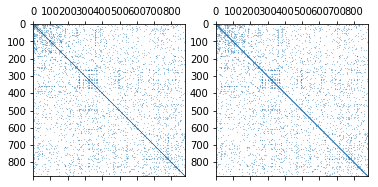

In [6]:
# We first create the degree vector of our graph :
degrees=np.sum(adjacency,0)
D_sqrt_inv= np.diag(1/np.sqrt(degrees))

laplacian_combinatorial = sparse.csr_matrix(np.diag(degrees)-adjacency)
laplacian_normalized = sparse.csr_matrix(D_sqrt_inv @ laplacian_combinatorial @ D_sqrt_inv)

plt.subplot(121)
plt.spy(laplacian_combinatorial,markersize=0.1)
plt.subplot(122)
plt.spy(laplacian_normalized,markersize=0.1)

In [7]:
G=nx.from_numpy_matrix(np.asmatrix(adjacency))

lap=nx.laplacian_matrix(G)
lap_a=lap.toarray()
lap_c_a=laplacian_combinatorial.toarray()

np.amax(lap_a-lap_c_a)

0.0

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [8]:
#laplacian =  laplacian_combinatorial
laplacian =  laplacian_normalized

#pcq qu'on peut facilement comparer avec NX # Either laplacian_combinatorial or laplacian_normalized.
## we can compare both, but don't do each operation twice
type(laplacian) ## quick check, easier to do linear algebra on csr type

scipy.sparse.csr.csr_matrix

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [9]:
vals,vects = scipy.linalg.eigh(laplacian.toarray())
#vals_sparse, _ = sparse.linalg.eigsh(laplacian,100, which='SM')
vals.sort()
print(vals[0])

eigenvalues, eigenvectors = np.linalg.eigh(laplacian.toarray())
print(eigenvalues[0])

lam=nx.laplacian_spectrum(G)
print(lam[0])

lam_np, _=np.linalg.eig(lap_a)
lam_np.sort()
print(lam_np[0])

#assert eigenvectors.shape == (n_nodes, n_nodes)

## can be very expensive, downsample more if takes too long O(n^3)... (should be fine with ours)
## watch the order, depending on the eigensolver
#tester le computation time de chaque solver et prendre le moins long ?

1.437751407248759e-16
1.239629268340074e-16
-2.7282942156872904e-17
0j


/Users/AlexCionca/miniconda3/envs/ntds_2018/lib/python3.7/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


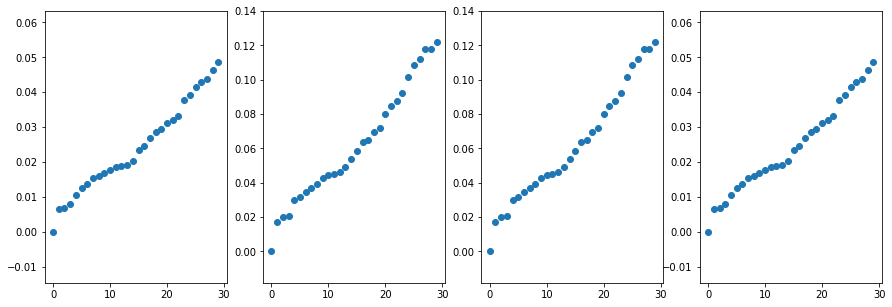

In [69]:
eig_min=0
eig_max=30
x = range(eig_min,eig_max,1)

plt.figure(figsize=(15,5))


plt.subplot(141)
#plt.plot(vals)
plt.scatter(x,vals[eig_min:eig_max])
#plt.scatter(vals[:exe],list(np.ones((exe,1))))

plt.subplot(142)
#plt.plot(lam)
plt.scatter(x,lam[eig_min:eig_max])
#plt.scatter(lam[:exe],list(np.ones((exe,1))))

plt.subplot(143)
#plt.plot(lam_np)
plt.scatter(x,lam_np[eig_min:eig_max])
#plt.scatter(lam_np[:exe],list(np.ones((exe,1))))
            
plt.subplot(144)
#plt.plot(eigenvalues)
plt.scatter(x,eigenvalues[eig_min:eig_max])
#plt.scatter(eigenvalues[:exe],list(np.ones((exe,1))))

In [11]:
#print(eigenvectors[:,0])
#print(vects[:,0])
sum(vects[:,0]**2) #gives the norm of the vector which is equal to 1

0.9999999999999952

Justify your choice of eigensolver.

**Your answer here.**

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

**Your answer here.**

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Your answer here.**

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

**Your answer here.**

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

**Your annswer here.**

Should be indicating vector of giant component, so full of 1's (normalized) for our network which is connected

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

In [12]:
# Your code here.
## the first should be 0.

**Your answer here.**

How many connected components are there in your graph? Answer using the eigenvalues only.

In [13]:
# Your code here.
# 1 since first eigenvalue is zero

Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**Your answer here.**

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**Your answer here.**

Embed in an Euclidian Space, for visualisation for example, the visualisation has to "show" properties of the graph
Laplacian Eigenmaps are also useful for dimensionality reduction using neighborhood information of the dataset (each data point is a node of the graph)

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [14]:
n_eig=12

# Eigenvalues and eigenvectors are computed using the 
vals_s, eigenvectors_s = sparse.linalg.eigsh(laplacian,n_eig,maxiter=400000, which='SM')

# Eigenvectors matrix is Re-normalized by the degrees
eigenV = D_sqrt_inv @ eigenvectors_s

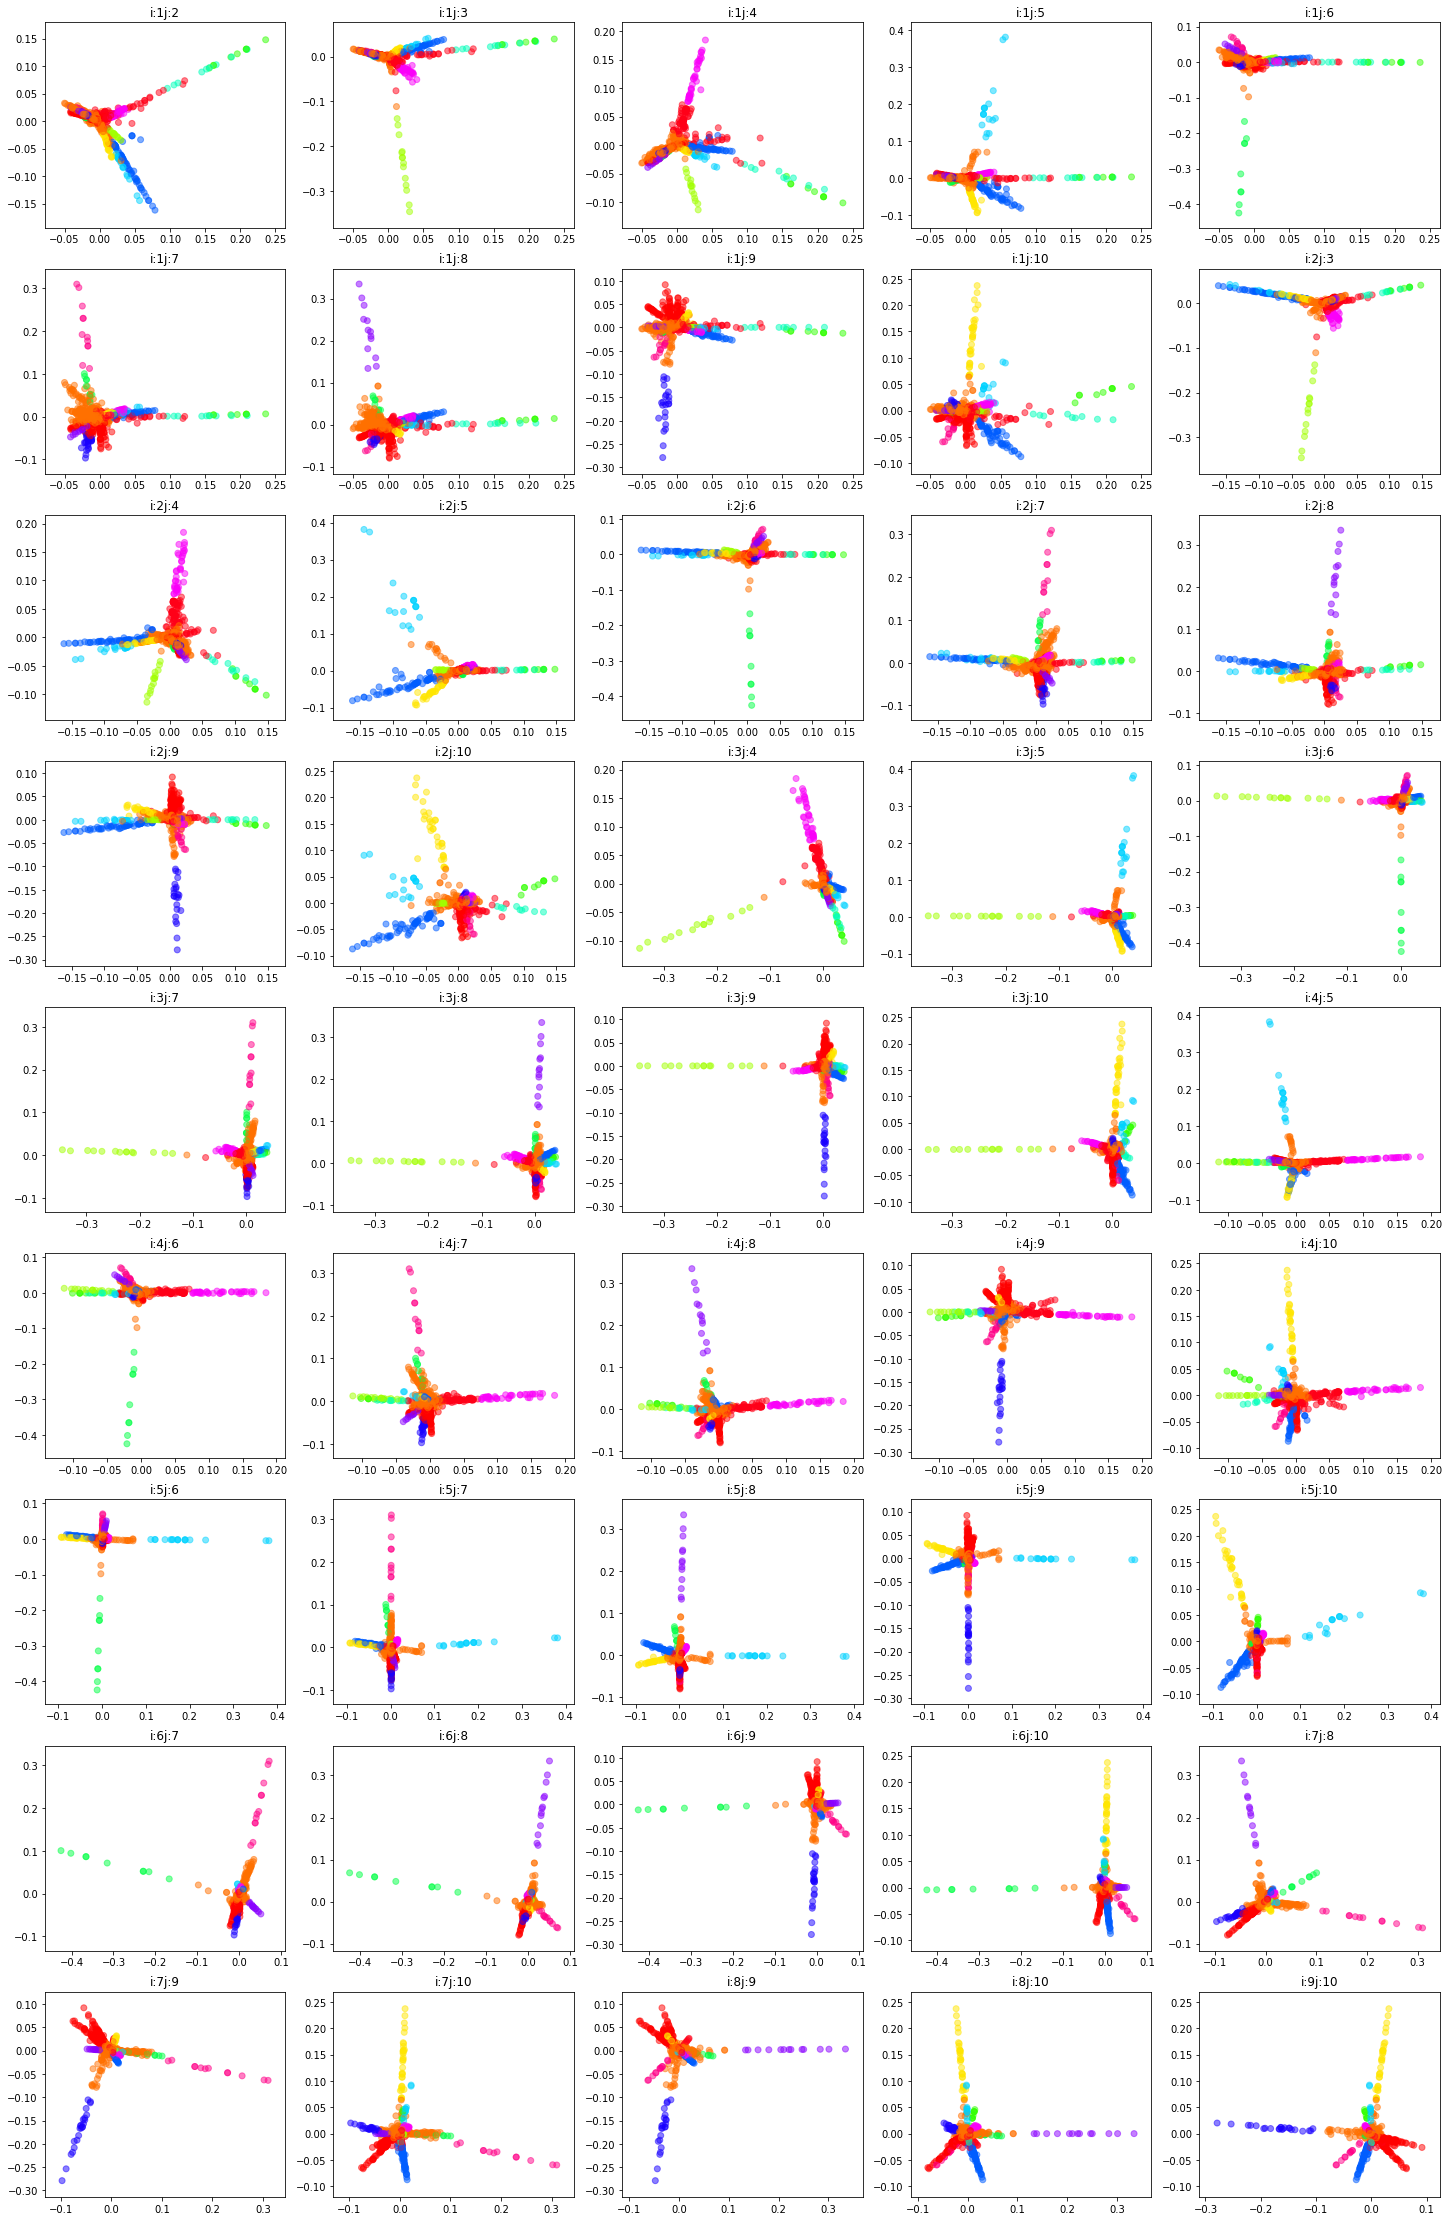

In [66]:
k=1

plt.figure(figsize=(25,40))

for i in range(1, len(eigenvectors_s[0])-1,1):
    for j in range(i+1,len(eigenvectors_s[0])-1,1):
        x=eigenvectors_s[:,i]
        y=eigenvectors_s[:,j]
        plt.subplot(9,5,k)
        strange='i:'+ str(i) +'j:'+ str(j)
        plt.title(strange)
        plt.scatter(x, y, alpha=0.5, c=K_means.labels_, cmap='hsv')
        k+=1
        


Plot the nodes embedded in 2D. Comment on what you see.

Text(0, 0.5, '9th Eigenvector')

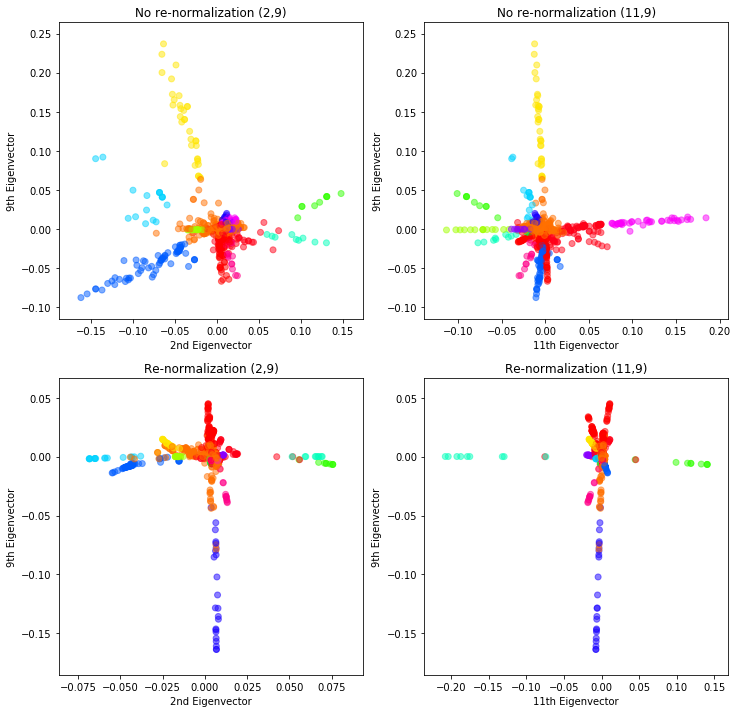

In [70]:
plt.figure(figsize=(12,12))

x= eigenvectors_s[:,2]
y= eigenvectors_s[:,10]
z= eigenvectors_s[:,4]

plt.subplot(2,2,1)
plt.scatter(x, y, alpha=0.5, c=K_means.labels_, cmap='hsv');
plt.title("No re-normalization (2,9)")
plt.xlabel("2nd Eigenvector")
plt.ylabel("9th Eigenvector")

plt.subplot(2,2,2)
plt.scatter(z, y, alpha=0.5, c=K_means.labels_, cmap='hsv');
plt.title("No re-normalization (11,9)")
plt.xlabel("11th Eigenvector")
plt.ylabel("9th Eigenvector")

x= eigenV[:,2]
y= eigenV[:,9]
z= eigenV[:,11]

plt.subplot(2,2,3)
plt.scatter(x, y, alpha=0.5, c=K_means.labels_, cmap='hsv');
plt.title("Re-normalization (2,9)")
plt.xlabel("2nd Eigenvector")
plt.ylabel("9th Eigenvector")

plt.subplot(2,2,4)
plt.scatter(z, y, alpha=0.5, c=K_means.labels_, cmap='hsv');
plt.title("Re-normalization (11,9)")
plt.xlabel("11th Eigenvector")
plt.ylabel("9th Eigenvector")

**Your answer here.**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Your answer here.**

LES DISTANCES

A COMPLETER <br>
Points close to each other on the manifold are mapped close to each other in the low-dimensional space, preserving local distances.
https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Laplacian_eigenmaps

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

**Your answer here.**

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [63]:
n_eigV=13
k=14

H=eigenvectors_s[:,1:n_eigV]
#H=eigenV[:,1:n_eigV]

print(np.shape(H))

K_means=KMeans(n_clusters = k, random_state=0).fit(H)

for i in range(k):
    print(i,':',len(np.argwhere(K_means.labels_ == i)))
    
## turn a graph into a set of vectors and run k-means on it, rows are samples, columns are features

(881, 11)
0 : 127
1 : 413
2 : 34
3 : 14
4 : 9
5 : 9
6 : 9
7 : 17
8 : 65
9 : 23
10 : 13
11 : 39
12 : 12
13 : 97


### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

In [ ]:
# Your code here.
## order by clusters, the order is no longer arbitrary, comment on wether this shows a structure in the network
## maybe the clusters will give sequels? MCU, Pirates of the carribeans...
## the clusters number order doesn't matter

**Your answer here.**

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [ ]:
# Your code here.

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

In [ ]:
# Your code here.

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**